# Initial Analysis for Political Parties' Interests

## Mounting the Google Drive
The Quotebank data is stored on Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installs

In [2]:
!python -m pip install --upgrade pip
!pip install pytrends
!pip install nltk
!pip install tld
!pip install pyarrow
!pip install qwikidata
!pip install sentence-transformers
!pip install transformers
!pip install umap-learn
!pip install hdbscan
!pip install tqdm

     |████████████████████████████████| 1.7 MB 4.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 412 kB 4.2 MB/s            
     |████████████████████████████████| 78 kB 3.0 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 3.1 MB 24.7 MB/s            
     |████████████████████████████████| 3.3 MB 35.6 MB/s            
     |████████████████████████████████| 1.2 MB 28.6 MB/s            
     |████████████████████████████████| 59 kB 7.4 MB/s             
     |████████████████████████████████| 895 kB 49.4 MB/s            
     |████████████████████████████████| 596 kB 49.6 MB/s            
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=0909f7607ff6ae174bdbb16c73bf5b95baf727b6464fd97d0c868da49adab67d
  Stored in directory: /root/

## Imports

In [3]:
import bz2
import json
import umap
import hdbscan
import nltk
import ast
import torch
import pyarrow
import os.path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as f
from tqdm import tqdm
from tld import get_tld
from itertools import chain
from datetime import datetime
from pytrends import dailydata
from google.colab import drive
from collections import Counter
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from collections import defaultdict
from pytrends.request import TrendReq
from nltk.cluster import KMeansClusterer
from sentence_transformers import SentenceTransformer
from transformers import BertModel, BertTokenizer
from sklearn.preprocessing import StandardScaler, normalize
from qwikidata.entity import WikidataItem, WikidataLexeme, WikidataProperty
from qwikidata.linked_data_interface import get_entity_dict_from_api

## Constants

In [4]:
# Whether to create a parsed file from the Quotebank dataset.
PARSE_QUOTEBANK = True

# Colorblind-friendly color palette.
COLORS = ['#377EB8', '#FF7F00', '#4DAF4A', '#F781BF']

# A mapping between a year and the file that contains the input of that year.
QUOTES_BY_YEAR = {year: f"/content/drive/MyDrive/politicians-quotes-{year}.json.bz2" for year in range(2015, 2021)}

# A mapping between a party and quotes of its members
WIKIDATA_POLITICIANS_PATH = f"/content/drive/MyDrive/wikidata_politicians.csv"

# Path to parquet file used for Wikidata information
WIKIDATA_PATH = f"/content/drive/MyDrive/Quotebank_Wikidata/speaker_attributes.parquet"

# Path to file with mapping between q-codes and labels
WIKIDATA_LABELS_PATH = f"/content/drive/MyDrive/Quotebank_Wikidata/wikidata_labels_descriptions_quotebank.csv.bz2"

# Wikidata columns that are represented by q codes
WIKIDATA_QCODES_COL = ['occupation', 'party']

# The name of the single-value general stats
VALUE_STATS = {'nan_speakers', 'nan_percentage', 'avg_quote_len', 'num_quotes'}

# The name of the counter general stats
COUNTER_STATS = {'quotes_by_date', 'qids_count'}

# The year for which the data will be analyzed
YEAR = 2018

## Setup

In [5]:
# Connect to Google trends API
pytrend = TrendReq()
# NLTK setup
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## General Quotebank Analysis

In [ ]:
def describe_chunks(df_reader):
    """
    Compute general statistics about the dataset.
    """
    # Initialize single-value stats
    stats = {stat: 0 for stat in VALUE_STATS}
    # Initialize counter stats
    stats = {**stats, **{stat: Counter() for stat in COUNTER_STATS}}
    for chunk in df_reader:
        # Compute stats per chunk
        stats['nan_speakers'] += (chunk['speaker'] == 'None').sum()
        stats['avg_quote_len'] += chunk['quotation'].str.len().sum(axis=0)
        stats['num_quotes'] += len(chunk)
        quotes_by_date = Counter(
            (chunk.groupby(by=chunk["date"].dt.date).count())["quoteID"].T.to_dict()
        )
        stats['quotes_by_date'] += quotes_by_date
        stats['qids_count'] += Counter(chain.from_iterable(chunk['qids']))
    
    stats['avg_quote_len'] = stats['avg_quote_len'] / stats['num_quotes']
    stats['nan_percentage'] = stats['nan_speakers'] / stats['num_quotes']
    return stats

In [ ]:
# Analyze data chunk by chunk
df_reader = pd.read_json(f'quotes-{YEAR}.json.bz2', lines=True,
                         compression='bz2', chunksize=10000)
stats = describe_chunks(df_reader)

In [ ]:
# Print full data stats
pd.DataFrame.from_dict({name: [stats[name]] for name in VALUE_STATS}).style.hide_index()

nan_percentage,nan_speakers,num_quotes,avg_quote_len
0.351031,9558032,27228451,134.068001


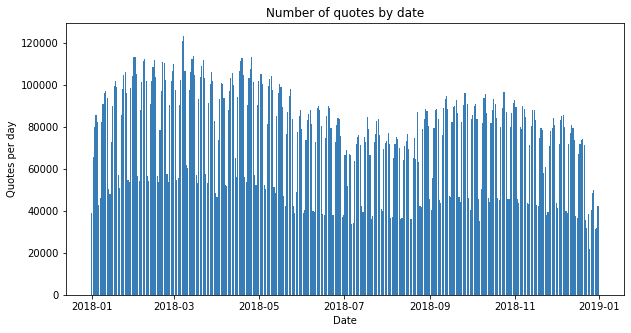

In [ ]:
# Plot the number of quotes by date
plt.figure(figsize=(10, 5))
plt.bar((stats['quotes_by_date']).keys(),
        stats['quotes_by_date'].values(),
        color=COLORS[0]);
plt.title('Number of quotes by date')
plt.ylabel('Quotes per day')
plt.xlabel('Date');

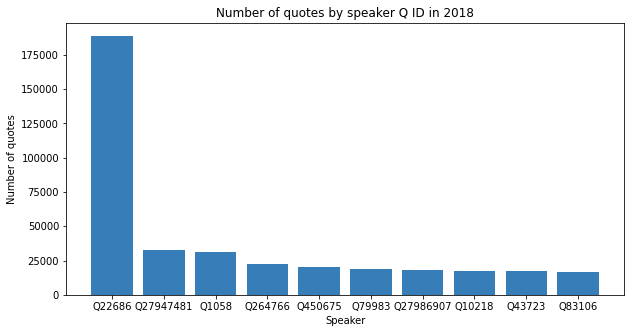

In [ ]:
# Plot the number of quotes for the most common speakers
most_common_qids = stats['qids_count'].most_common(10)
plt.figure(figsize=(10, 5))
plt.bar([t[0] for t in most_common_qids],
        [t[1] for t in most_common_qids],
        color=COLORS[0])
plt.title(f'Number of quotes by speaker Q ID in {YEAR}')
plt.xlabel('Speaker')
plt.ylabel('Number of quotes');

## Quote Parsing

The Quotebank data is too large to handle in-memory in a single DataFrame. Therefore, for our initial analyses we select only the quotes from 2018 that were uttered by politicians. We detect these quotes by looking at the Q IDs of the speakers, merging them with Wikidata based on the Q ID, resolving the Q IDs of their profession and filtering those quotes that belong to politicians.

In [ ]:
# A list of politicians of interest.
politicians = ["Barack Obama", "George W. Bush", "Donald Trump", "John McCain",
            "Mitt Romney", "Hillary Clinton", "Benjamin Netanyahu",
            "Narendra Modi", "Joe Biden", "Theresa May", "Boris Johnson"]

In [ ]:
def get_politicians_data(year):
  """
  Given a year, parses the Quotebank data and creates a file containing
  the quotes of politicians from that year.
  """
  path_to_out = QUOTES_BY_YEAR[year]
  path_to_file = f'/content/drive/MyDrive/Quotebank/quotes-{year}.json.bz2'
  with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
      for i, instance in enumerate(s_file):
        # Load a sample.
        instance = json.loads(instance)
        if (sum([politician in instance['speaker'] for politician in politicians]) > 0):
          # Write sample to new file.
          d_file.write((json.dumps(instance)+'\n').encode('utf-8'))
        print(i)

In [ ]:
# get_politicians_data(YEAR)

In [ ]:
# Store politicians data in DataFrame.
data = pd.read_json(QUOTES_BY_YEAR[YEAR], lines=True)

Below, we look at a couple of quotes that belong to Donald Trump and Barack Obama, two of our politicians of interest.



In [ ]:
trump_quotes = data[data["speaker"].str.contains("Donald Trump")]
trump_quotes.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2018-05-08-001245,A constructive deal could easily have been str...,President Donald Trump,[Q22686],2018-05-08 18:36:49,8,"[[President Donald Trump, 0.5633], [None, 0.38...",[http://baynews9.com/fl/tampa/news/2018/05/08/...,E
1,2018-09-26-003692,actually admitted that they're going after far...,President Donald Trump,[Q22686],2018-09-26 00:00:00,138,"[[President Donald Trump, 0.6838], [None, 0.30...",[http://dailyherald.com/news/20180926/kavanaug...,E
3,2018-07-30-004176,always leaves room for negotiation.,President Donald Trump,[Q22686],2018-07-30 20:44:00,4,"[[President Donald Trump, 0.6616], [None, 0.33...",[http://www.10news.com/newsy/trump-25-billion-...,E
4,2018-10-30-005630,an incredible leader who is respected by every...,President Donald Trump,[Q22686],2018-10-30 03:10:00,3,"[[President Donald Trump, 0.358], [Cathy McMor...",[http://m.spokesman.com/stories/2018/oct/30/pr...,E
5,2018-04-21-003582,and he is already a proven liar and leaker.,President Donald Trump,[Q22686],2018-04-21 21:38:52,1,"[[President Donald Trump, 0.7394], [None, 0.16...",[https://mic.com/articles/189012/this-week-in-...,E


In [ ]:
obama_quotes = data[data["speaker"].str.contains("Barack Obama")]
obama_quotes.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
21,2018-02-12-035226,I cannot paint.,Barack Obama,[Q76],2018-02-12 13:50:00,2,"[[Barack Obama, 0.8319], [Kehinde Wiley, 0.090...",[http://www.chicagotribune.com/news/ct-obama-p...,E
35,2018-11-03-029313,"incessant, non-stop attempts to divide us with...",Barack Obama,[Q76],2018-11-03 01:43:21,3,"[[Barack Obama, 0.7987], [None, 0.164], [Donal...",[http://thehill.com/homenews/news/414678-obama...,E
106,2018-10-22-004462,All right? I believe in a fact-based reality. ...,President Barack Obama,[Q76],2018-10-22 21:36:28,1,"[[President Barack Obama, 0.7669], [None, 0.21...",[http://www.rawstory.com/2018/10/dont-believe-...,E
176,2018-10-26-096425,The biggest threat to our democracy is cynicis...,President Barack Obama,[Q76],2018-10-26 19:37:30,3,"[[President Barack Obama, 0.8994], [None, 0.08...",[http://cbsnews.com/news/live-stream-obama-ral...,E
201,2018-11-14-125138,was the day I was getting my hair and makeup d...,Barack Obama,[Q76],2018-11-14 16:01:00,1,"[[Barack Obama, 0.7869], [None, 0.2131]]",[http://www.wmagazine.com/story/michelle-obama...,E


## Quotes and Google Trends

One on of our theories is that politicians talk about subjects of interest. For example, when a major event takes place, we would expect to hear about it in the news, and more importantly, we would expect political stakeholders to talk about it. However, not all politicians may pay the same amount of attention to all events.

We plot the Google search trends against the number of quotes on specific subjects for Donald Trump and Barack Obama, two leaders from opposing parties.

In [ ]:
def plot_trend(all_quotes, keyword, year, ax, speaker_name):
  """
  Given a list of quotes, a keyword of interest and a year, plot the Google
  search trend against the politicians' trends of uttering related quotes.
  """
  # Get quotes stats from Quotebank
  relevant_quotes = all_quotes[all_quotes["quotation"].str.contains(keyword)]
  quotes_by_date = relevant_quotes.groupby(by=relevant_quotes['date'].dt.date)
  quotes_occ = pd.DataFrame(quotes_by_date['numOccurrences'].sum(),
                           columns=['numOccurrences'])

  # Get Google Trends data
  pytrend.build_payload(kw_list=[keyword], geo='US',
                        timeframe=f'{year}-01-01 {year}-12-31')
  df_google = pytrend.interest_over_time()

  # Treat missing quote trend values for a nicer plot
  idx = pd.date_range(f"01-01-{year}", f"12-31-{year}")
  quotes_occ = quotes_occ.reindex(idx, fill_value=0)

  # Scale trend
  quotes_occ["numOccurrences"] = StandardScaler().fit_transform(
    quotes_occ[["numOccurrences"]]
  )

  # Scale trend
  df_google[keyword] = StandardScaler().fit_transform(df_google[[keyword]])

  # Plot trends
  ax.plot(quotes_occ, label=f"{speaker_name} quote trend", color=COLORS[0])
  df_google.plot(y=keyword, use_index=True, ax=ax,
                 label='Google trend', color=COLORS[1])
  
  ax.set_title(f'Quotes & Search Trend for "{keyword}"')
  ax.set_xlabel('Date')
  ax.set_ylabel('Trend')
  ax.legend()

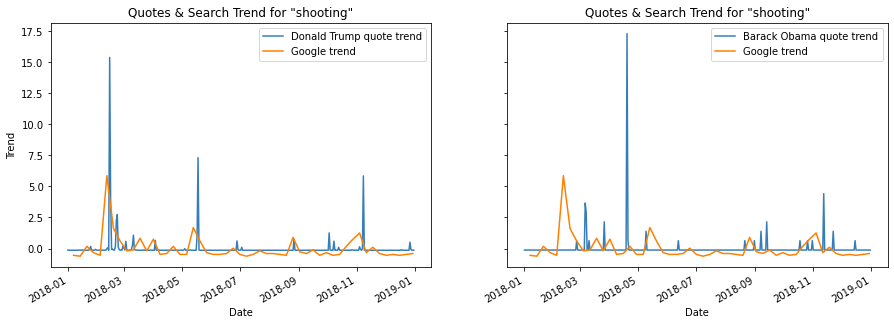

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=2, sharey=True)
plot_trend(trump_quotes, "shooting", 2018, axs[0], "Donald Trump")
plot_trend(obama_quotes, "shooting", 2018, axs[1], "Barack Obama")

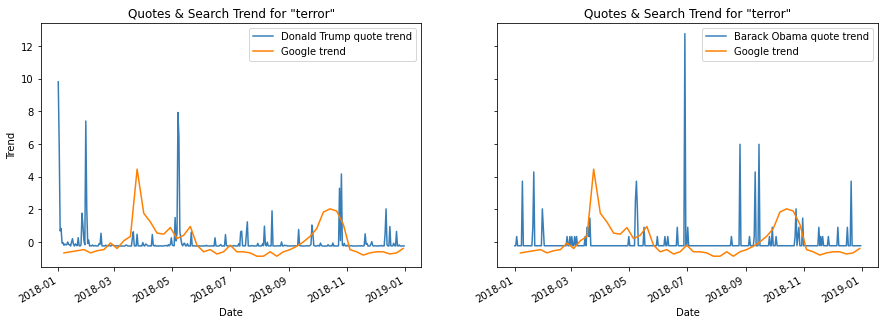

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=2, sharey=True)
plot_trend(trump_quotes, "terror", 2018, axs[0], "Donald Trump")
plot_trend(obama_quotes, "terror", 2018, axs[1], "Barack Obama")

## Most common words

We analyze the most common words said by Trump and Obama to see if we can find a pattern. For the current analysis, we only look at the most common nouns of each politician after tokenizing and preprocessing their quotes.

In [ ]:
def preprocess_text(text):
  """
  Apply NLTK preprocessing operations to extract more meaningful data
  from the quotes.
  """
  tokens = nltk.word_tokenize(text)
  # Remove stopwords
  stopwords_removed = [word for word in tokens if word not in stopwords.words("english")]
  tagged = nltk.pos_tag(stopwords_removed)
  # Return only nouns
  return [word for word, tag in tagged if tag.startswith('N') and word.isalpha()]

In [ ]:
# Count most common words for Donald Trump
trump_words_cnt = Counter(preprocess_text(" ".join(trump_quotes["quotation"].str.lower())))

In [ ]:
trump_words_cnt.most_common(30)

[('people', 14746),
 ('country', 8374),
 ('president', 6797),
 ('time', 5574),
 ('trump', 5079),
 ('states', 4818),
 ('lot', 4650),
 ('deal', 4224),
 ('world', 4175),
 ('things', 4015),
 ('years', 4005),
 ('trade', 3746),
 ('way', 3711),
 ('something', 3200),
 ('thing', 3179),
 ('countries', 2794),
 ('russia', 2741),
 ('democrats', 2729),
 ('security', 2508),
 ('nothing', 2311),
 ('china', 2304),
 ('border', 2256),
 ('job', 2242),
 ('news', 2217),
 ('money', 2042),
 ('year', 1971),
 ('today', 1946),
 ('house', 1867),
 ('america', 1826),
 ('day', 1824)]

In [ ]:
# Count most common words for Barack Obama.
obama_words_cnt = Counter(preprocess_text(" ".join(obama_quotes["quotation"].str.lower())))

In [ ]:
obama_words_cnt.most_common(30)

[('people', 1585),
 ('time', 654),
 ('president', 577),
 ('world', 574),
 ('way', 533),
 ('country', 533),
 ('politics', 488),
 ('years', 441),
 ('democracy', 419),
 ('things', 402),
 ('work', 359),
 ('power', 343),
 ('something', 325),
 ('life', 323),
 ('america', 320),
 ('obama', 272),
 ('day', 271),
 ('thing', 266),
 ('states', 263),
 ('change', 258),
 ('election', 255),
 ('house', 254),
 ('history', 254),
 ('kind', 247),
 ('vote', 243),
 ('today', 225),
 ('trump', 222),
 ('americans', 212),
 ('women', 211),
 ('man', 204)]

While Donald Trump talks about _Russia_, _China_, _money_, and _democrats_, Barack Obama chooses to talk about _democracy_, _change_, and _work_. This simple approach has revealed that although some of the main nouns are shared between the representants of the two parties, there are also differences that should be futher analyzed to figure out if they can tell us more about their parties.

In [ ]:
# Using this option to display the full quotes
pd.set_option('display.max_colwidth', None)

In [ ]:
obama_quotes[obama_quotes["quotation"].str.contains('gay')]['quotation'].head()

3028                                                                                                                                                                                             the scene of an uprising against police repression that led to a key turning point in the struggle for the civil rights of lesbian, gay, bisexual, and transgender (LGBT) Americans.
20109                                                                                                                                                                                        (W) hen I hear people say they don't like identity politics, I think it's important to remember that identity politics doesn't just apply when it's black people or gay people or women,
31804    I still have to stand here at a lecture and devote some time to saying that black people and white people and Asian people and Latin American people and women and men and gays and straights... are all human, that our differences are superficia

In [ ]:
trump_quotes[trump_quotes["quotation"].str.contains('gay')].head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
1861,2018-01-18-038590,I cannot vibe with gays,President Donald Trump,[Q22686],2018-01-18 17:42:12,1,"[[President Donald Trump, 0.5233], [None, 0.4767]]",[http://fuse.tv/2018/01/offset-migos-boss-life-queer-lyric-controversy-yfn-lucci],E
4127,2018-01-15-062263,"On the surface it may seem like Trump is giving a speech to one of our nation's most beloved icons -- the American farmer. But, the Farm Bureau actually represents a small, tight-knit clan of wealthy, far-right ideologues who oppose gay marriage and gun-free zones, support racist voter suppression laws, and want to gut social welfare programs like Medicaid.",President Donald Trump,[Q22686],2018-01-15 17:55:00,1,"[[President Donald Trump, 0.5711], [None, 0.4289]]",[http://www.southeastfarmpress.com/farm-policy/trump-afbf-what-did-everyone-else-say],E
15536,2018-10-29-025115,"has shown himself to be completely shameless when it comes to throwing anybody under the bus to score political points. As a gay man, I feel that threat.",President Donald Trump,[Q22686],2018-10-29 00:17:18,4,"[[President Donald Trump, 0.6485], [None, 0.2856], [Nickie Antonio, 0.0659]]","[https://www.ohio.com/news/20181028/blue-wave-lgbt-candidates-hope-for-rainbow-wave, https://www.times-gazette.com/news/20181031/blue-wave-lgbtq-candidates-hope-for-rainbow-wave, https://www.dispatch.com/news/20181101/blue-wave-lgbtq-candidates-hope-for-rainbow-wave, https://www.indeonline.com/news/20181101/blue-wave-lgbtq-candidates-hope-for-rainbow-wave]",E
24896,2018-02-13-074191,"It's not just for me. I got out there because -- it's not just gay kids, I think that everybody can relate to being different or feeling like they're not good enough or they'll never make it because they're from a small town, or maybe they just don't feel like they're good enough.",President Donald Trump,[Q22686],2018-02-13 16:14:48,2,"[[President Donald Trump, 0.3286], [None, 0.3038], [Mike Pence, 0.2501], [Adam Rippon, 0.1175]]","[http://people.com/sports/winter-olympics-2018-adam-rippon-message-haters/, http://people.com/sports/winter-olympics-2018-adam-rippon-gus-kenworthy-competing-openly-gay-athletes/]",E
30200,2018-01-26-124359,"Tomorrow marks the 73rd anniversary of the liberation of Auschwitz-Birkenau, the Nazi death and concentration camp in Poland. We take this opportunity to recall the Nazis' systematic persecution and brutal murder of six million Jewish people. In their death camps and under their inhuman rule, the Nazis also enslaved and killed millions of Slavs, Roma, gays, people with disabilities, priests and religious leaders, and others who courageously opposed their brutal regime,",President Donald Trump,[Q22686],2018-01-26 21:54:07,1,"[[President Donald Trump, 0.8092], [None, 0.1908]]",[http://israelnationalnews.com/News/News.aspx/241218],E


In [ ]:
# Resetting the column width
pd.reset_option('display.max_colwidth')

## News websites and speakers

### Helpers

In [ ]:
def get_domain_names(urls):
  """
  Get a list with all domain names for the urls list given as parameter.
  """
  domains = []
  for url in urls:
    res = get_tld(url, as_object=True)
    domains.append(res.domain)
  return domains

def standardize_speaker_name(x):
  """
  Standardize a speaker name to a common one from the list of politicians.
  """
  plts = np.array(politicians)
  return plts[[p in x for p in plts]][0]

### News websites' preference for a speaker

In [ ]:
# Do not alter original data
new_data_domains = data.copy()
# Convert urls into domain names -> this takes 1 minute
new_data_domains['urls'] = new_data_domains['urls'].apply(get_domain_names)

In [ ]:
# Standardize speaker names in order to be able to group quotes
new_data_domains['speaker'] = new_data_domains['speaker'].apply(standardize_speaker_name)
new_data_domains.head(10)
# Gather all sites that retreieved a politician's quotes
by_politician = new_data_domains.groupby('speaker')['urls'].agg(lambda x: list(chain.from_iterable(x.values))).reset_index()

In [ ]:
# Get number of quotes retrieved by a website, for each politician
politicians_websites = []
for index, row in by_politician.iterrows():
  p_websites = pd.DataFrame(Counter(row['urls']).most_common(5),
                                columns=["Website name", "{}".format(row['speaker'])])
  politicians_websites.append(p_websites)

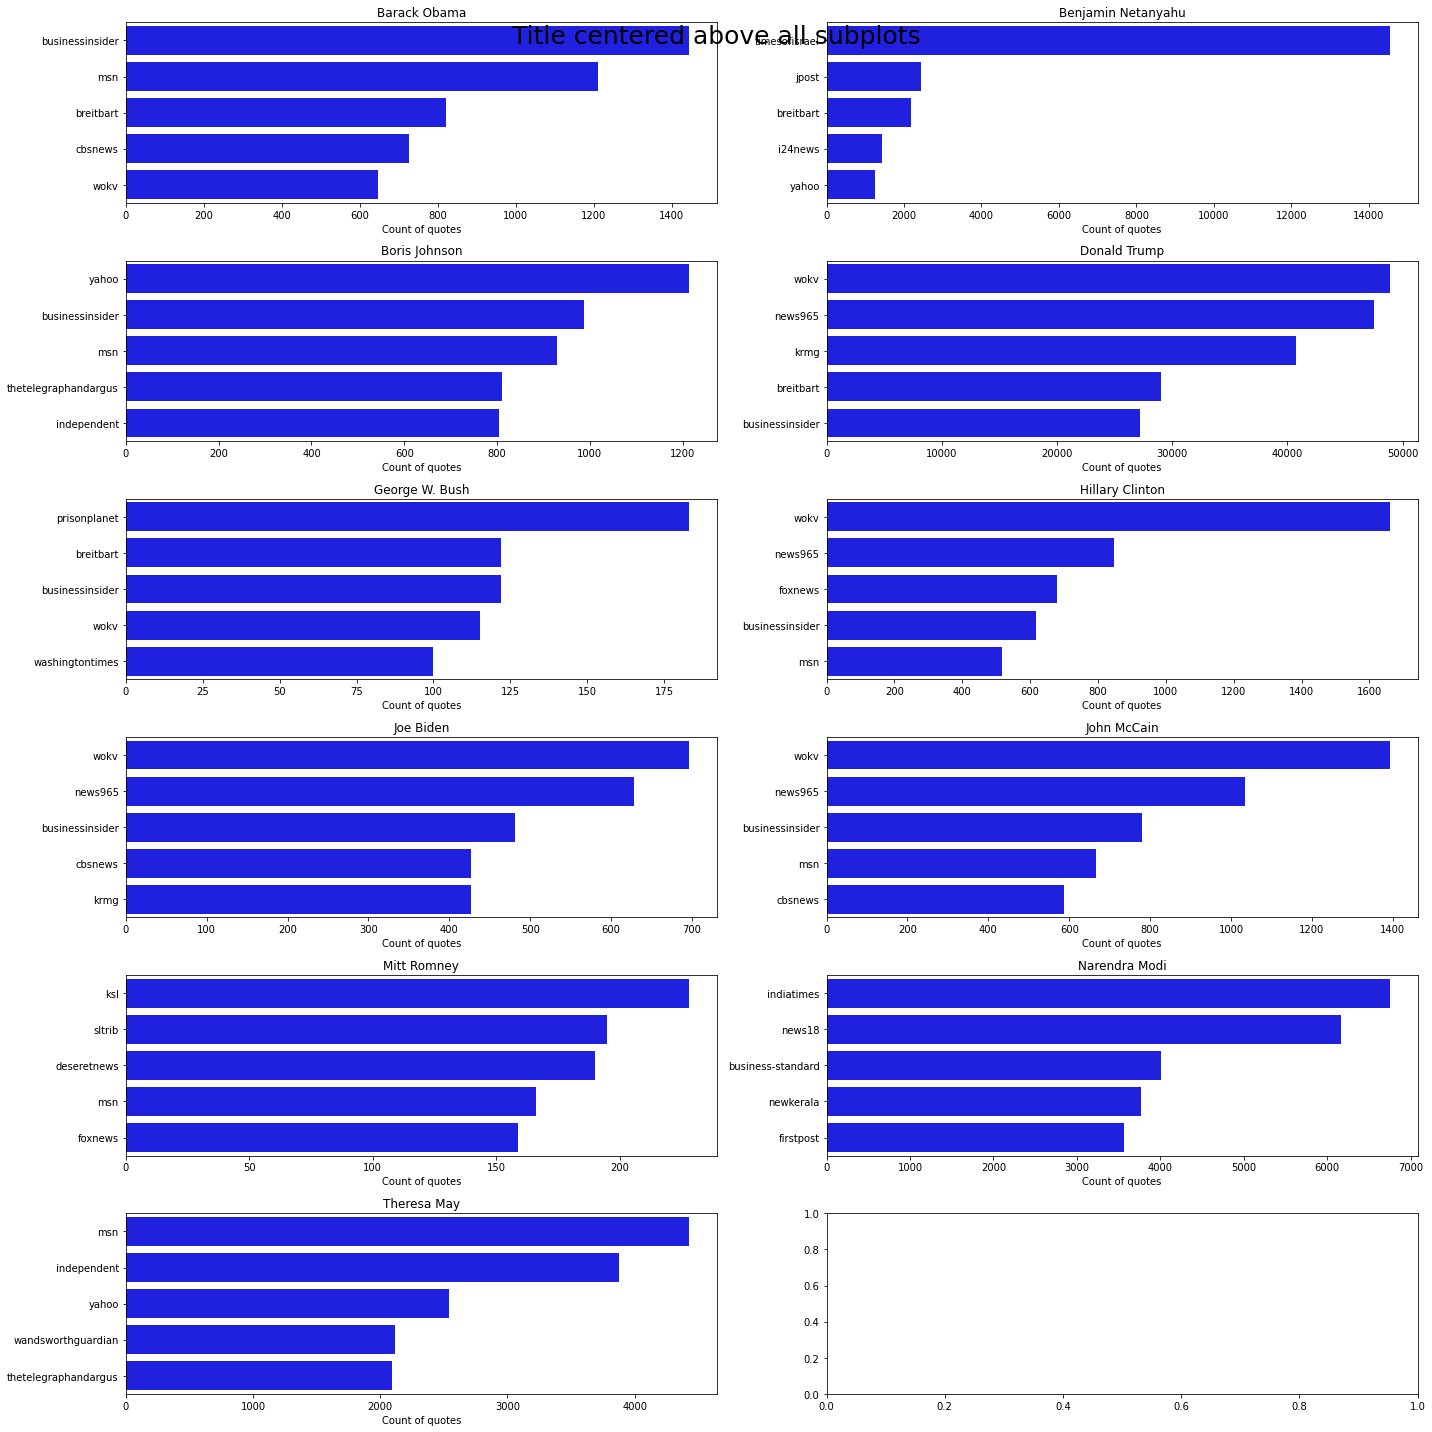

In [ ]:
# Plot the websites, preferences for each politician
w = 2
h = len(politicians_websites) // w + 1
fig, ax = plt.subplots(h, w, figsize=(20, 20))
# TODO: See why title is not showing
# fig.suptitle("Title centered above all subplots", fontsize=25)
for i in range(h):
  j = 0
  while i * w + j < len(politicians_websites) and j < w:
    sbplt = ax[i, j]
    ax_sns = sns.barplot(x=politicians_websites[j + i * w].columns[-1], y="Website name", 
                         data=politicians_websites[j + i * w], ax=sbplt, color='blue')#.set(xscale="log")
    ax_sns.set(xlabel="Count of quotes", ylabel=None, title=politicians_websites[j + i * w].columns[-1])
    j += 1
fig.tight_layout()

## Wikidata q-codes, first approach

### Helpers

In [ ]:
def convert_qcodes_en(q_codes):
  """
  Function for transforming wikidata q codes into list of english aliases or
  labels related to the specific q code. If list of q_codes is given aggregate
  all the words corresponding to each code. 
  """
  codes_values = []
  if q_codes is not None:
    for q_code in q_codes:
      s = get_entity_dict_from_api(q_code)
      s_value = []
      if len(s.get('aliases', {}).get("en", [])) > 0:
        s_value.extend([v["value"] for v in s['aliases']["en"]])
      if s.get('labels', {}).get("en", {}) != dict():
        s_value.append(s['labels']["en"]["value"])

      codes_values.extend(s_value)
  if len(codes_values) == 0:
    return None

  return codes_values

### Converting Q codes into list of aliases and label aggregated

In [ ]:
# Read .parquet file into a dataframe
wikidata = pd.read_parquet(WIKIDATA_PATH, engine='pyarrow')

In [ ]:
# Small test for converting wikidata qcodes into words (just first 5 entries)
new_wikidata = wikidata.iloc[:5].copy()
for name in WIKIDATA_QCODES_COL:
  new_wikidata[name] = new_wikidata[name].apply(convert_qcodes_en) 
new_wikidata.head(1)

## Quotebank dataset preprocessing 

### Helpers

In [94]:
def convert_qcodes(l, df):
  """
  Convert list of qcodes to labels
  """
  return None if l is None else list(map(lambda x: df.loc[x]['Label'] if x in df.index else None, l))


def infer_format(time_stmp):
    if time_stmp[6:8] == '00':
        time_stmp = time_stmp[:5]
        dt_format = '+%Y'
    else:
        time_stmp = time_stmp[:8]
        dt_format = '+%Y-%m'
    return time_stmp, dt_format

    
def get_party_membership(q_code):
    """
    Function for obtaining party membership intervals for speaker with q_code
    """
    tmp = []
    if q_code is not None:
        try:
            s = get_entity_dict_from_api(q_code)
        except:
            return []
        if len(s.get("claims", {}).get("P102", [])) > 0:
            # Separate case when there is only one political party for a speaker
            # Just consider it as the correct party
            if len(s["claims"]["P102"]) == 1:
                if s["claims"]["P102"][0]["mainsnak"].get("datavalue", {}).get("value", {}).get("id") is not None:
                        party = s["claims"]["P102"][0]["mainsnak"]["datavalue"]["value"]["id"]
                        tmp.append([party, datetime.strptime(*infer_format('+2008-07-31T00:00:00Z')),
                                            datetime.strptime(*infer_format('+2020-05-01T00:00:00Z'))])
            else:
                for i, v in enumerate(s["claims"]["P102"]):
                    if v["mainsnak"].get("datavalue", {}).get("value", {}).get("id") is not None:
                        party = v["mainsnak"]["datavalue"]["value"]["id"]
                        if party in q_codes_labels.index:
                            party = q_codes_labels.loc[party]['Label']
                            start_time, end_time = None, None
                            if len(v.get('qualifiers', {}).get('P580', [])) > 0:
                                if v['qualifiers']['P580'][0].get('datavalue', {}).get("value", {}).get('time') is not None:
                                    start_time = v['qualifiers']['P580'][0]["datavalue"]["value"]["time"]
                            if len(v.get('qualifiers', {}).get('P582', [])) > 0:
                                if v['qualifiers']['P582'][0].get('datavalue', {}).get("value", {}).get('time') is not None:
                                    end_time = v['qualifiers']['P582'][0]["datavalue"]["value"]["time"]
                            if start_time is not None and end_time is not None:
                                tmp.append([party, datetime.strptime(*infer_format(start_time)),
                                            datetime.strptime(*infer_format(end_time))])
                            elif start_time is not None and end_time is None:
                                tmp.append([party, datetime.strptime(*infer_format(start_time)),
                                            datetime.strptime(*infer_format('+2020-05-01T00:00:00Z'))])
                            else:
                                continue

    if len(tmp) == 0:
        return []

    return np.array(tmp, dtype=object)


def map_speaker_to_party(qids):
    speaker_to_parties = {}
    df_speaker_to_parties = pd.DataFrame(index=range(len(qids)))
    df_speaker_to_parties["party"] = 0
    df_speaker_to_parties["qid"] = 0
    df_speaker_to_parties["party"] = df_speaker_to_parties["party"].astype('object')

    qids = qids[:7]
    for i, qid in tqdm(enumerate(qids)):
        if qid not in speaker_to_parties:
            # Create entry in dict of mappings between politicians and party memberships intervals
            speaker_to_parties[qid] = get_party_membership(qid)
            df_speaker_to_parties.iloc[i]['qid'] = qid

    df_speaker_to_parties.at[list(range(len(qids))), 'party'] = list(speaker_to_parties.values())
    return df_speaker_to_parties
    # df_speaker_to_parties.to_csv()

def get_politicians_party(df):
    # TODO: Test this
    speaker_to_parties = {}

    for i, sample in tqdm(df.iterrows()):
        qid = sample['qids']
        if qid not in speaker_to_parties:
            # Create entry in dict of mappings between politicians and party memberships intervals
            speaker_to_parties[qid] = get_party_membership(qid)
        new_sample = sample
        # Map parties to parties membership intervals
        new_sample['party'] = speaker_to_parties[qid]
        # Get quote date
        quote_date = datetime.strptime(new_sample['quoteID'][:7], '%Y-%m')
        # Select the party membership interval corresponding to the quote date
        if new_sample['party'] is not None:
            new_sample['party'] = [p for p in new_sample['party'] if p[1] <= quote_date < p[2]]
            # If no membership interval found, take the last party
            if len(new_sample['party']) == 0:
                continue
                # new_sample['party'] = [speaker_to_parties[qid][-1]]
            # If multiple parties found  take the last one
            if len(new_sample['party']) > 1:
                new_sample['party'] = [speaker_to_parties[qid][-1]]
            df.iloc[i] = new_sample
            
    return df


def get_politicians_entire_data(year, wiki_politicians, proba_threshold=0.6, sub_samples=None):
    # Given a year, parses the Quotebank data and creates a zip containing
    # the quotes of politicians that belong to a party from that year.

    to_remove_keys = ('numOccurrences', 'phase', 'urls', 'date', 'probas')
    path_to_out = QUOTES_BY_YEAR[year]
    path_to_file = f'/content/drive/MyDrive/Quotebank/quotes-{year}.json.bz2'
    with bz2.open(path_to_file, 'rb') as s_file:
        with bz2.open(path_to_out, 'wb') as d_file:
            for i, instance in tqdm(enumerate(s_file)):
                if sub_samples is not None and i > sub_samples:
                    break
                # Load a sample.
                instance = json.loads(instance)
                # If there is un unknown speaker with the highest probability, 
                # therefore no qids or the attributed speaker has a lower
                # probability than a threshold, then pass. Also keep only politicians
                # with a single qid, to be sure that he is the one who said the quote
                if len(instance['qids']) == 0 or float(instance['probas'][0][1]) < proba_threshold \
                or len(instance['qids']) > 1:
                    continue
                # Remove unnecessary keys
                for key in to_remove_keys:
                    instance.pop(key, None)
                qids = instance['qids'].copy()
    
                # Get corresponding wiki_politicians sample for the specific qid in quotebank
                # This happens only if quotebank speaker is politician in a party
                try:
                    # wikidata_sample = pd.DataFrame(wiki_politicians.loc[qid]).T
                    wikidata_sample = wiki_politicians.loc[qid]
                except KeyError:
                    continue
                # Replace qid for politcian
                instance['qids'] = qid
                # Merge quotebank sample with wikidata sample
                instance['party'] = wikidata_sample['party']
                instance['party_qcodes'] = wikidata_sample['party_qcodes']
                # Write to file
                d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

### Get wikidata politicians (DO NOT RUN THIS AGAIN, FILE ALREADY CREATED)

In [7]:
# Mapping between wikidata q codes and their labels
q_codes_labels = pd.read_csv(WIKIDATA_LABELS_PATH, compression='bz2', index_col='QID')

In [ ]:
q_codes_labels.head(3)

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks


In [ ]:
# Read wikidata .parquet file into a dataframe
wikidata = pd.read_parquet(WIKIDATA_PATH, engine='pyarrow').set_index('id')
party_qcodes = wikidata['party']
# Map qcodes to labels
wikidata = wikidata[WIKIDATA_QCODES_COL].progress_applymap(lambda lst: convert_qcodes(lst, q_codes_labels))
wikidata['party_qcodes'] = party_qcodes.values
wikidata.head(3)

100%|██████████| 18111962/18111962 [24:31<00:00, 12307.74it/s] 


,occupation,party
id,,
Q23,"[politician, military officer, farmer, cartogr...",[independent politician]
Q42,"[playwright, screenwriter, novelist, children'...",None
Q1868,"[writer, lawyer, librarian, information scient...",None


In [ ]:
# Total entries in wikidata
wikidata.shape

(9055981, 3)

In [ ]:
# Keep only politicians
wikidata_politicians = wikidata.loc[wikidata['occupation'].apply(lambda lst: 'politician' in str(lst))]
wikidata_politicians.head(3)

,occupation,party,party_qcodes
id,,,
Q23,"[politician, military officer, farmer, cartogr...",[independent politician],[Q327591]
Q207,"[politician, motivational speaker, autobiograp...",[Republican Party],[Q29468]
Q368,"[military officer, politician]",[independent politician],[Q327591]


In [ ]:
# Total number of politicians
wikidata_politicians.shape

(659455, 3)

In [ ]:
# Save table with wikidata politicians
wikidata_politicians.to_csv('/content/drive/MyDrive/wikidata_politicians.csv')

### Get quotebank politicians (already made, only for 2018, for analysis purpose)

In [ ]:
# Read dataframe with wikidata politicians
wikidata_politicians = pd.read_csv(WIKIDATA_POLITICIANS_PATH).set_index('id')
# Keep only the ones belonging to a party
wikidata_politicians_in_party = wikidata_politicians.loc[~wikidata_politicians['party'].isna()]
print("There are {} politicians belonging to at least a party in Wikidata !".format(wikidata_politicians_in_party.shape[0]))

There are 305302 politicians belonging to at least a party in Wikidata !


In [ ]:
# Create zipped file for a specific year, with all Quotebank's entries where
# the speaker is a politician belonging to at least one party
get_politicians_entire_data(YEAR, wikidata_politicians_in_party, proba_threshold=0.6)

27228451it [1:02:45, 7231.21it/s]


### Code

In [8]:
# Read the Quotebank data just created
quotebank_data = pd.read_json(QUOTES_BY_YEAR[YEAR], lines=True)

In [9]:
quotebank_data.shape

(2527083, 6)

In [10]:
# Replace nan parties (corresponding to when a politician interrupted his political activity)
quotebank_data['party'] = quotebank_data['party'].apply(lambda x: x.replace('nan', '"no_party"'))

In [11]:
# Get parties list
parties_list = quotebank_data['party'].values

In [12]:
# Map a string representing a list, to a list
for i, value in tqdm(enumerate(parties_list)):
    try:
        parties_list[i] = ast.literal_eval(parties_list[i])
    except:
        print(parties_list[i])

2527083it [00:33, 76312.16it/s]


In [13]:
# Number of parties
parties_2018 = set(chain.from_iterable(quotebank_data['party'].values))
parties_2018.remove('no_party')
print("Number of parties in year {} is: {}\n".format(YEAR, len(parties_2018)))

Number of parties in year 2018 is: 2661



In [14]:
# Parties with the most quotes (note that each quote may belong to multiple parties,
# as there are speakers belonging to multiple parties over time)
parties_quotes_nr = Counter(chain.from_iterable(quotebank_data['party'].values))
sorted_parties_quotes_nr = list(sorted(parties_quotes_nr.items(), key=lambda x: x[1], reverse=True))
df_sorted_parties_quotes_nr = pd.DataFrame(sorted_parties_quotes_nr, columns=['Party', 'Number of quotes'])
df_sorted_parties_quotes_nr.head(10)

,Party,Number of quotes
0,Republican Party,878771
1,Democratic Party,634535
2,Bharatiya Janata Party,129360
3,Independence Party of America,104301
4,Conservative Party,79051
5,Indian National Congress,77471
6,Labour Party,59292
7,independent politician,55590
8,Liberal Party of Australia,39614
9,Australian Labor Party,32379


In [15]:
# Number of quotes by politician (20 most influential)
quotes_by_politician = quotebank_data.groupby('speaker')['quotation'].count()
quotes_by_politician = quotes_by_politician.sort_values(ascending=False)
df_quotes_by_politician = pd.DataFrame(quotes_by_politician).reset_index().rename(columns={"quotation": "number of quotes"})
df_quotes_by_politician.head(10)

,speaker,number of quotes
0,President Donald Trump,68982
1,President Trump,32700
2,Narendra Modi,26131
3,Rahul Gandhi,14228
4,Benjamin Netanyahu,12681
5,Mike Pompeo,12403
6,Harry Roque,12045
7,Rodrigo Duterte,11564
8,Vladimir Putin,11242
9,Arun Jaitley,8907


In [16]:
# Number of speakers belonging to each party, if politician belonged to multiple
# parties, count him in each of them

speakers_parties = quotebank_data.drop_duplicates(subset=['speaker'])['party']

party_members = defaultdict(lambda: 0)
speakers_parties = speakers_parties.values

for parties in tqdm(speakers_parties):
    for p in parties:
        party_members[p] += 1

party_members = list(party_members.items())
party_members = sorted(party_members, key=lambda x: x[1], reverse=True)
df_party_members = pd.DataFrame(party_members, columns=['Party', 'Members'])
df_party_members.head(10)

100%|██████████| 36739/36739 [00:00<00:00, 801202.81it/s]


,Party,Members
0,Democratic Party,6563
1,Republican Party,6180
2,Bharatiya Janata Party,995
3,Labour Party,937
4,Indian National Congress,814
5,Conservative Party,689
6,independent politician,521
7,Australian Labor Party,498
8,Liberal Party of Canada,385
9,Christian Democratic Union,341


#### Analysis when a single party per person is kept

The logic is the following: 
* If a speaker belonged to only one political party throughout his life, consider that party as the correct one, regardless of the quotation date.
*   If a speaker belonged to multiple parties:
    - Take the party whose (start_time, end_time) interval contains the quotation date. If a party of a speaker has a start_time, but not and end_time, consider the end_time == current_time. If a speaker has 2 parties with a start_time and no end_time, it means he belongs to multiple parties, therefore, take only the last one.




In [95]:
# Get party membership intervals for each speaker and save dataframe
quotebank_qids = quotebank_data['qids'].unique()

map_speaker_to_party(quotebank_qids)
# TODO: Check this


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
7it [00:08,  1.22s/it]
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

,party,qid
0,"[[Q3240730, 2008-07-01 00:00:00, 2020-05-01 00...",0
1,"[[Q29468, 2008-07-01 00:00:00, 2020-05-01 00:0...",0
2,"[[Q29468, 2008-07-01 00:00:00, 2020-05-01 00:0...",0
3,"[[Q24708, 2008-07-01 00:00:00, 2020-05-01 00:0...",0
4,"[[Q29552, 2008-07-01 00:00:00, 2020-05-01 00:0...",0
...,...,...
32963,0,0
32964,0,0
32965,0,0
32966,0,0


## BERT

In [96]:
# Check cuda runtime and set model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceTransformer('bert-base-nli-mean-tokens')
print(device)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

cuda


In [124]:
# Get a subset of quotebank
quotebank_subset = quotebank_data[:2500]

In [125]:
# Find sentence embeddings
sentence_embeddings = model.encode(list(quotebank_subset['quotation']), show_progress_bar=True)
# Reduce dimensionality of embeddings
umap_embeddings = umap.UMAP(n_neighbors=50, n_components=9, metric='cosine').fit_transform(sentence_embeddings)

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

In [126]:
# Cluster documents
cluster = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


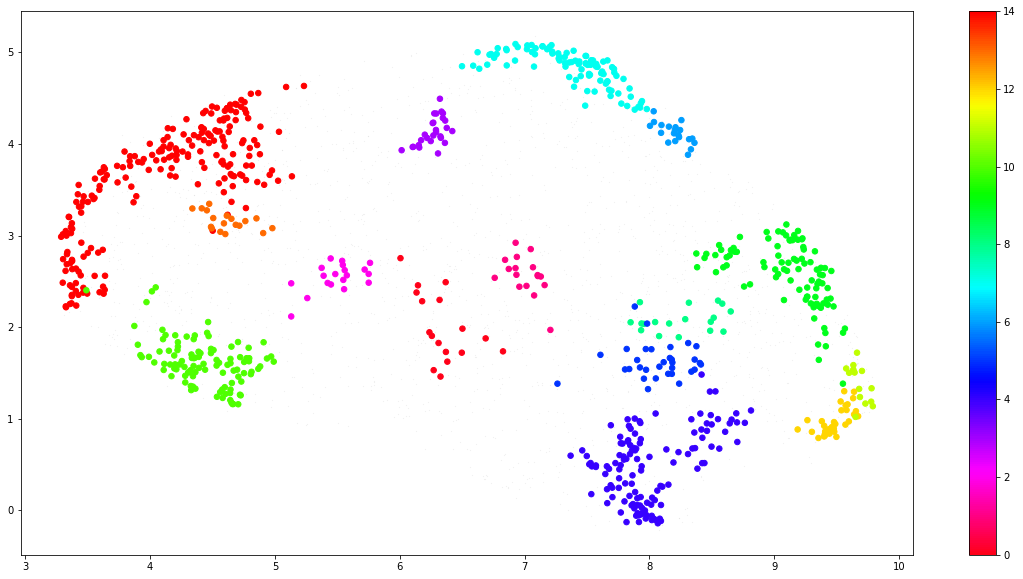

In [127]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=50, n_components=2, min_dist=0.0, metric='cosine').fit_transform(sentence_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_
quotebank_subset['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.005)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=30, cmap='hsv_r')
plt.colorbar()

In [131]:
# Check a cluster results
clusters = quotebank_subset.groupby('labels')[['quotation', 'party']].agg(list)
clusters.quotation.loc[12]

['and he is already a proven liar and leaker.',
 'Islamophobic, Turcophobic, xenophobic and racist.',
 "It's creating confusion and indecision.",
 "It's heartless. It's horrible.",
 'petty and, frankly, a waste of public resources',
 'scandalous and a disgraceful treatment',
 'sincerely regret the misfortune on the matter',
 'such false and maliciously defamatory allegations',
 'The State of the Nation feels really backward-facing to me,',
 'These are not productive times, when we have tariffs going both ways.',
 'This combination of poor performance and financial instability is neither acceptable nor sustainable.',
 'This emotional detachment is just terrible.',
 'Well, their numbers are wrong. So, fake news,',
 "What? You weren't correctly telling the truth? That's an outright lie. Correct?",
 "you're both liars.",
 "a woefully inaccurate reflection of women's achievement",
 'As fare as we are concerned the tender was illegitimate,',
 'extremely unsatisfactory given the gravity of th

**We can see bad words here**

In [ ]:
# Get the parties interested in topic 12
# TODO: check here, this needs improvements
Counter((map(lambda x: x[0][0], clusters.party.loc[3])))

Counter({'A': 3,
         'B': 9,
         'C': 8,
         'D': 9,
         'F': 1,
         'I': 1,
         'K': 1,
         'L': 5,
         'N': 1,
         'P': 2,
         'R': 80,
         'S': 1,
         'T': 1,
         'U': 4})

## Suggestions

*   Apply "get_membership_party" on yearly resulted dataframes

*   Tune parameters for UMAP - use this to get some insights https://pair-code.github.io/understanding-umap/
*   Tune parameters for HDBSCAN

* As research question
> Check parties interests over years

* Tokenize quotes 
* We will treat the missing qcodes in the final milestone












